# Data Cleaning and Transformation
**Transforming Essays using word2vec and Creating Average Representation Vectors of Essays** 

In [0]:
%%capture
from requiredimports import *
from dataloading import *
%matplotlib inline

**Data Cleaning and Transformation**

In [0]:
def essay_to_wordlist(essay_v, remove_stopwords):
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def essay_to_sentences(essay_v, remove_stopwords):
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [0]:
sentences = []

print ("Parsing sentences from all the Essays")
for essay_v in df_all["essay"]:
    sentences += essay_to_sentences(essay_v, remove_stopwords = True)
    
print ("Complete")

Parsing sentences from all the Essays
Complete


In [0]:
%%capture
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)
model.init_sims(replace=True)

model_name = "300features_40minwords_10context"
model.save(model_name)

**Word Embedding Visualization**



Let's see how these words cluster together!

In [0]:
def viswordembedding(word_to_use, topn_):
    okay = model.most_similar(word_to_use, topn = topn_)
    words_to_show = [word_to_use]
    words_vec = np.zeros((topn_+1, 300))
    words_vec[0,:] = model[word_to_use]

    for ii in range(0, len(okay)):
        words_to_show.append(okay[ii][0])    
        words_vec[ii+1,:] = model[okay[ii][0]]

    pca = PCA(n_components=2)
    pca.fit(words_vec)
    X = pca.transform(words_vec)
    xs = X[:, 0]
    ys = X[:, 1]

    plt.figure(figsize=(8,6))
    plt.scatter(xs, ys, marker = 'o')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title('Word Embedding Nearest Neighbors for ' + word_to_use)
    for i, w in enumerate(words_to_show):
        plt.annotate(
            w,
            xy = (xs[i], ys[i]), xytext = (3, 3),
            textcoords = 'offset points', ha = 'left', va = 'top')
    plt.savefig('wordembedding', bbox_inches = "tight")

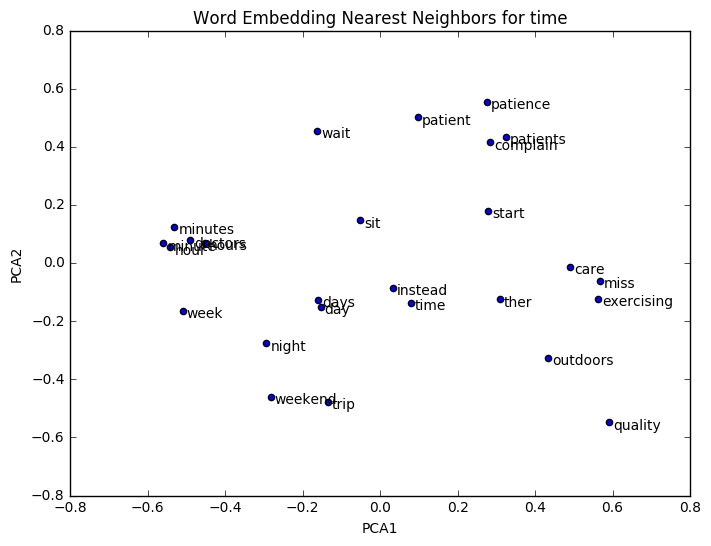

In [0]:
viswordembedding('time', 25)

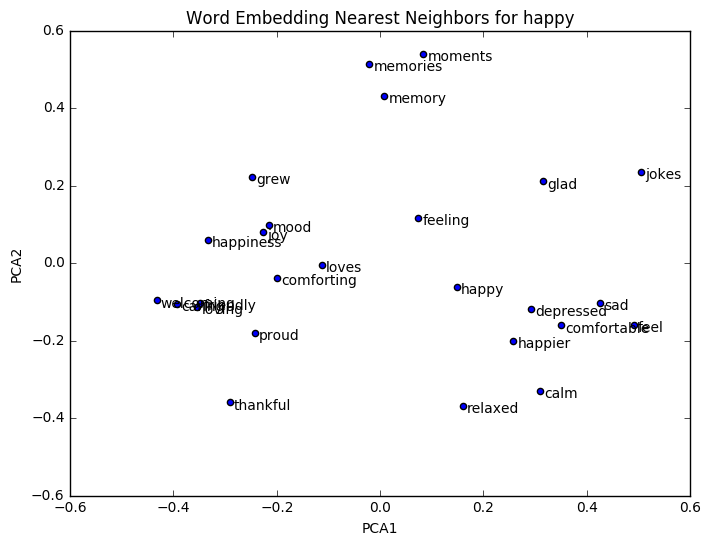

In [0]:
viswordembedding('happy', 25)

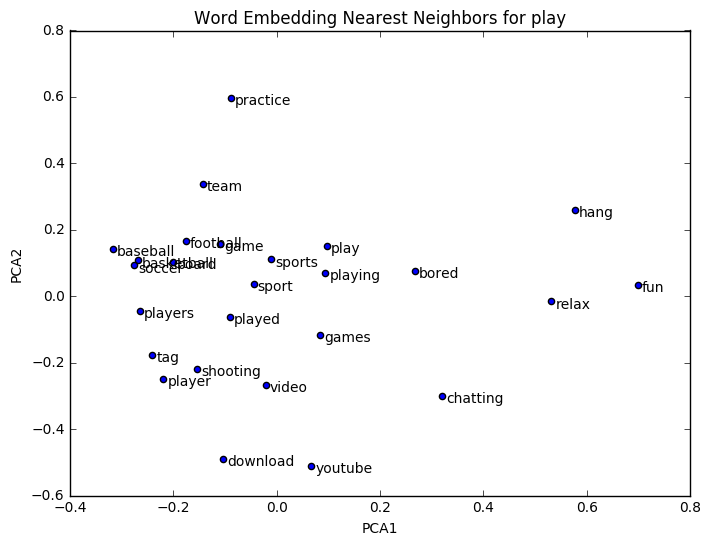

In [0]:
viswordembedding('play', 25)

**Create Average Feature Vectors for Essays**

For our analysis, we have to create averaged feature vectors of the words of each essay. We do this by using two functions **makeFeatureVec** and **getAvgFeatureVecs**. 



In [0]:
def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

In [0]:
print ("Creating average feature vecs for all Essays")

clean_essays = []
for essay_v in df_all["essay"]:
    clean_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True ))
essayDataVecs = getAvgFeatureVecs(clean_essays, model, num_features )

print ("Complete")

Creating average feature vecs for all Essays
Complete


**Principal Component Analysis of Vectorized Essays**



In [0]:
def visessay(set_no):
    
    indices = df_all[df_all['essay_set'] == set_no].index.tolist()
    
    if set_no == 8:
        indices = [i - 1 for i in indices]

    splicedDataVecs = essayDataVecs[indices,:]
    splicedGrades = np.array(df_all['domain1_score'][indices])
    
    n_grades = np.unique(splicedGrades)
    n = len(n_grades)
    color=iter(cm.rainbow(np.linspace(0,1,n)))
    
    pca = PCA(n_components=2)
    X = pca.fit_transform(splicedDataVecs)
    xs = X[:, 0]
    ys = X[:, 1]
    
    plt.figure(figsize=(6,4))
    
    for ii in range(n):
        index_ = [w for w in range(len(splicedGrades)) if splicedGrades[w] == n_grades[ii]]
        c = next(color)
        xs_ = xs[index_]
        ys_ = ys[index_]
        plt.scatter(xs_, ys_, marker = 'o', color = c)
        plt.title('PCA Plot of Essay Set ' + str(set_no))
        plt.xlabel('PCA1')
        plt.ylabel('PCA2')

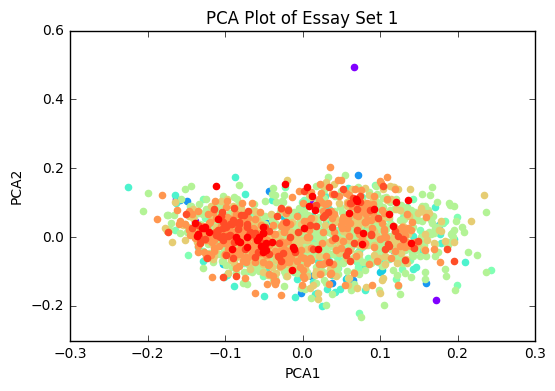

In [0]:
visessay(set_no = 1)

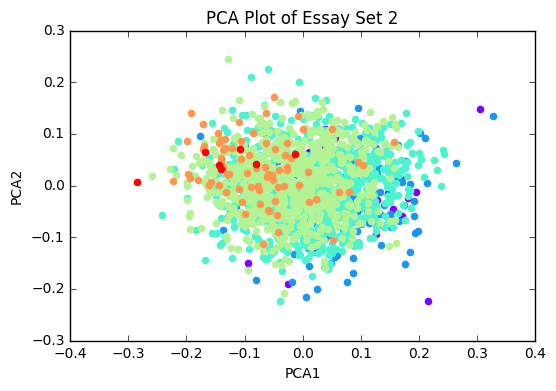

In [0]:
visessay(set_no = 2)

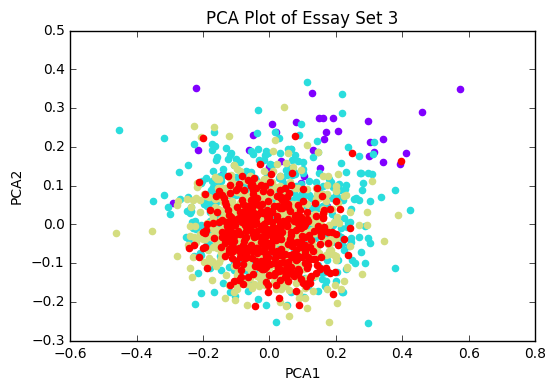

In [0]:
visessay(set_no = 3)

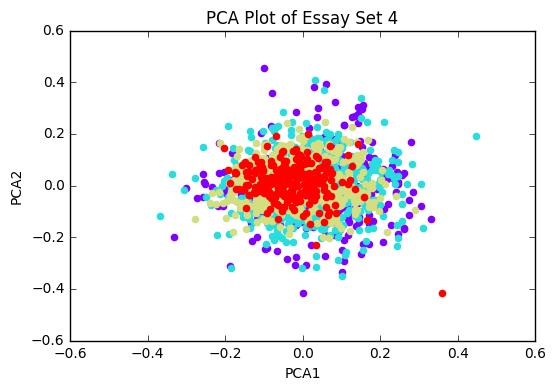

In [0]:
visessay(set_no = 4)

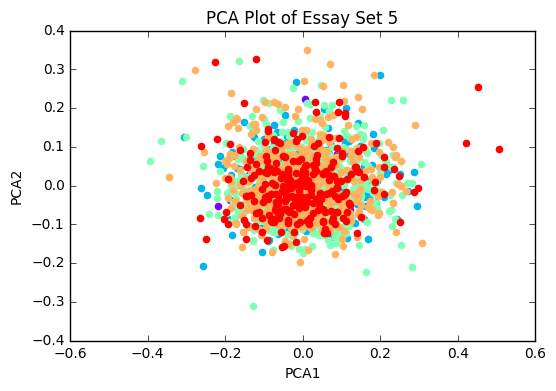

In [0]:
visessay(set_no = 5)

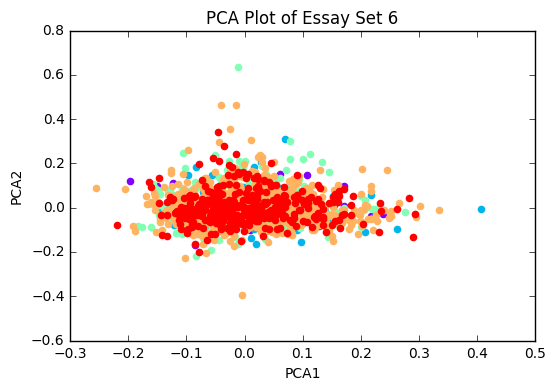

In [0]:
visessay(set_no = 6)

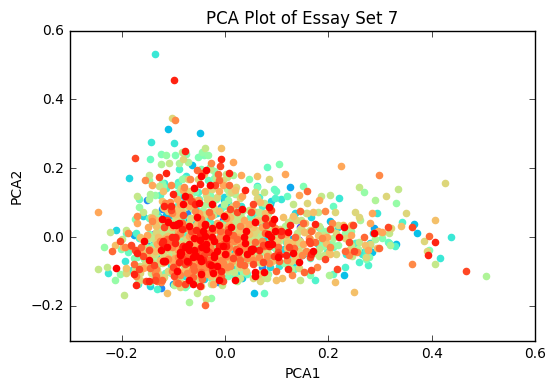

In [0]:
visessay(set_no = 7)

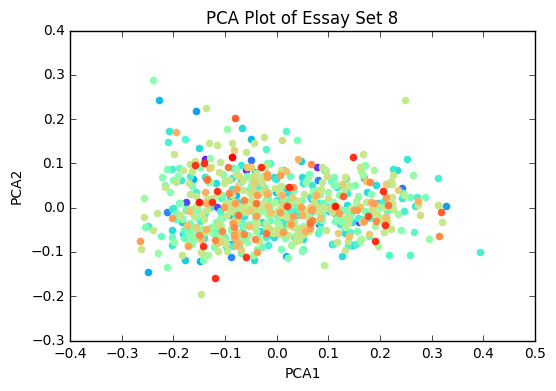

In [0]:
visessay(set_no = 8)